#### Valuing volatility derivatives

##### Futures Pricing Formula

* Valuation of volatility options and futures according to Grunbichler and Longstaff
* Semi-analytical (closed) solution for European volatility call options similar to BSM for equity options
* directly model volatility and assume a square root diffusion process
* Square root diffusion process modeled as stochastic differential equation
* This model has mean reversion characteristic
* Futures price of futures contract on the volatility index with maturity time T
* pricing of such a contract is done by taking expected value of index at maturity
* $F(v_0, T) = (1 - e^{-KT}) * \theta + e^{-KT} * v_0$
* Future value is exponentially weighted average of long-run mean and current value of index
* $\theta$: long run mean of the index
* $v_0$: current level of the index
* $K$: rate at which $v_t$ reverts to $\theta$


#### Compute futures terms structure by calculating futures price for different maturities

In [1]:
import math
## model parameters
v0 = 17.5  # initial level of volatility index
kappa = 0.1  # speed of mean reversion
theta = 20.0  # long-term index level
sigma = 2.0  # volatility of volatility
zeta = 0.0  # factor of the expected volatility risk premium
r = 0.01  # risk-free short rate

## option parameters
K = 20.0  # strike
T = 1.0  # time horizon in year fractions

In [2]:
import sys
sys.path.append('scripts/')

In [3]:
from srd_functions import *
futures_price(v0, kappa, theta, zeta, T)

17.7379064549101

In [4]:
import numpy as np
import seaborn as sns; sns.set()
import matplotlib
matplotlib.rcParams['font.family'] = 'serif'
import matplotlib.pyplot as plt
%matplotlib inline
maturities = np.linspace(0, 2, 24)
futures_prices = [futures_price(v0, kappa, theta, zeta, T)
                 for T in maturities]

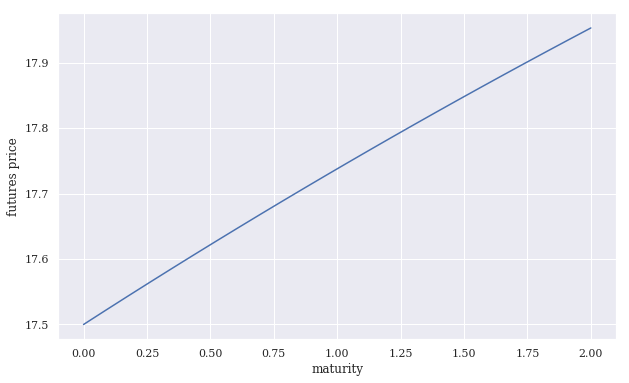

In [5]:
plt.figure(figsize=(10, 6));
plt.plot(maturities, futures_prices);
plt.xlabel('maturity');
plt.ylabel('futures price');

##### Options Pricing Formula

* European call option payoff function $max(V_T - K, 0)$ at maturity $T$
* Grunbichler and Longstaff derive an option pricing formula for a call option
* We need to compute a complementary non-central $\chi ^2$ distribution with $v$ degrees of freedom and non-centrality parameter $\lambda$

In [7]:
call_price(v0, kappa, theta, sigma, zeta, T, r, K)

2.2392650993330454

In [8]:
import numpy as np
import pandas as pd
option_values = []
strikes = np.linspace(15, 25)
option_values = [call_price(v0, kappa, theta, sigma, zeta, T, r, k)
                 for k in strikes]
data = pd.DataFrame(option_values, index=strikes,
                    columns=['call values', ])
data.index.name = 'strike'

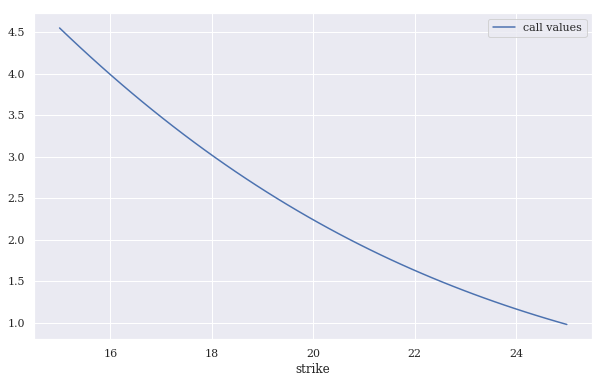

In [9]:
data.plot(figsize=(10, 6));

#### Monte Carlo Simulation

* Pricing simulation requires monte carlo to best estimate the true value of call option
* Discretize the SDE to obtain difference equation which can be evaluated numerically
* We use same parameters as before but we need to know the number of paths and the number of discrete steps
* Discretization of Square Root Diffusion process
    * Divide interva from $[0,T]$ into $M$ equal intervals with $M+1$ discrete points in time
    
* Implementation routine is broken into two functions
    * `generate_paths`: produces each path in the simulation
    * `call_estimator`: Collapses the path dimension to produce call estimate
    * $C(v_0, K,T) = e^{-rT} \frac{1}{I} \sum_{I=1}^{I} max(v_T^{i} - K, 0)$


In [10]:
## simulation parameters
M = 50  # time steps
I = 20000  # number of MCS paths
paths = generate_paths(v0, kappa, theta, sigma, T, M, I)

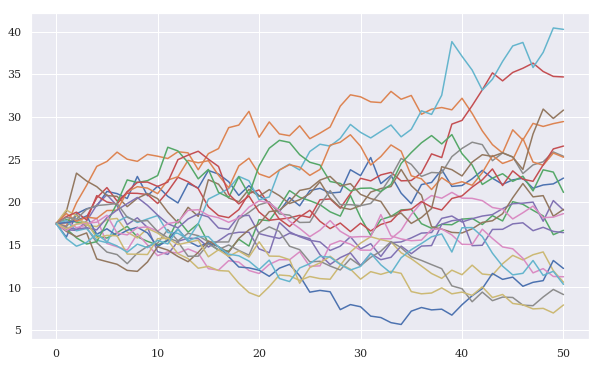

In [12]:
pd.DataFrame(paths[:, :20]).plot(legend=False, figsize=(10, 6));

In [13]:
%%time
estimates = []
for k in strikes:
    estimates.append(call_estimator(v0, kappa, theta, sigma,
                                    T, r, k, M, I))
data['estimates'] = estimates

CPU times: user 5.57 s, sys: 92.5 ms, total: 5.67 s
Wall time: 5.72 s


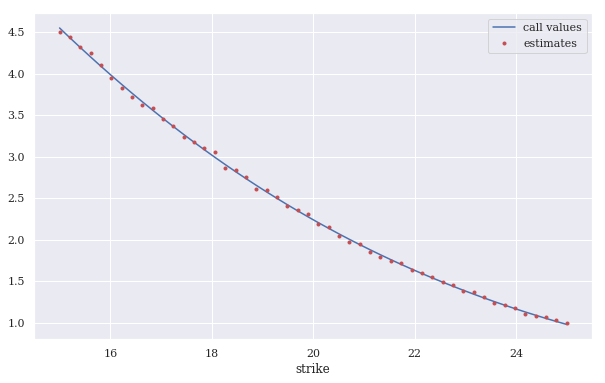

In [14]:
data.plot(style=['b', 'r.'], figsize=(10, 6));

#### Automation of MCS 

* Run simulation, benchmark against known valuations, store and analyze results
* Parameterize the simulation
* In general, the error ratios decrease the more time steps are included in the discretization and the number of paths in the simulation
* Variance reduction techniques can also increase the accuracy of the estimate

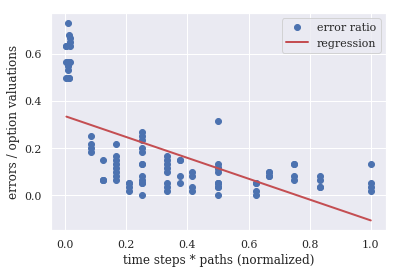

In [16]:
filename = 'data/simulation_results.h5'
from srd_simulation_results import plot_error_ratio
plot_error_ratio(filename)

In [17]:
import pandas as pd
h5 = pd.HDFStore(filename, 'r')
data = h5['sim_results']
h5.close()
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 96 entries, 0 to 95
Data columns (total 19 columns):
ab_val_err     96 non-null float64
abs_tol        96 non-null float64
anti_paths     96 non-null bool
av_val_err     96 non-null float64
end_date       96 non-null datetime64[ns]
error_ratio    96 non-null float64
errors         96 non-null int64
mo_match       96 non-null bool
opt_prices     96 non-null float64
paths          96 non-null int64
rel_tol        96 non-null float64
runs           96 non-null int64
seed           96 non-null int64
sim_name       96 non-null object
start_date     96 non-null datetime64[ns]
time_min       96 non-null float64
time_opt       96 non-null float64
time_sec       96 non-null float64
time_steps     96 non-null int64
dtypes: bool(2), datetime64[ns](2), float64(9), int64(5), object(1)
memory usage: 13.7+ KB


In [18]:
data.groupby(['mo_match']).mean()[['error_ratio']]

,error_ratio
mo_match,
False,0.193750
True,0.169097


In [19]:
data.groupby(['mo_match', 'anti_paths']).mean()[['error_ratio', 'errors']]

error_ratio     errors
mo_match anti_paths                        
False    False          0.206944  12.416667
         True           0.180556  10.833333
True     False          0.159028   9.541667
         True           0.179167  10.750000

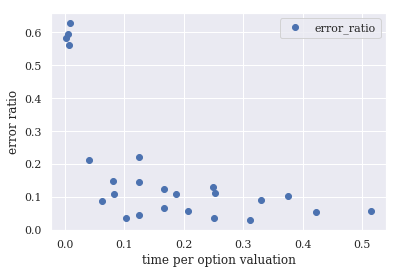

In [20]:
df = data.groupby(['time_steps', 'paths']).mean()[['error_ratio', 'time_opt']]
df.plot(x='time_opt', y='error_ratio', style='bo');
plt.xlabel('time per option valuation');
# @savefig gl96_error_ratio_time.pdf
plt.ylabel('error ratio');

#### Model Calibration

* Market based valuation approach
* Previous sections used assumed parameters in a theoretical valuation approach
* By using live market data and minimizing the differenc between estimates and real prices we can calibrate our models to improve pricing
* Parameters are determined for the model which best replicate liquid vanilla options 
* We then use these parameters to value more exotic derivatives via MCS

* Assume each option is written on a single unit of the underlying
* 1 point of the VSTOXX index translates into 1EUR

* Define an error function to be minimized
* For implementation we need 
    * valuation_function: values the call option for an array of strikes and set of params
    * error_function: errors are computed between the estimated and the quotes vanilla option prices
    * model_calibration: global and local optimum to using scipy.
* This model for option pricing does not accurately reflect market prices. The difference is sometimes greater than the tick price for an option
* This model does not include the fact of frequent and significant positive jumps in levels

In [21]:
import pandas as pd
path = 'data/'
h5 = pd.HDFStore(path + 'vstoxx_option_quotes.h5', 'r')
option_quotes = h5['option_quotes']

In [24]:
option_quotes['DATE'] = pd.to_datetime(option_quotes['DATE'])
option_quotes['MATURITY'] = pd.to_datetime(option_quotes['MATURITY'])
option_quotes.iloc[25:35]

,DATE,EXP_YEAR,EXP_MONTH,TYPE,STRIKE,PRICE,MATURITY,TTM
46244,2014-03-31,2014,5,C,26.0,0.60,2014-05-16,0.126
46245,2014-03-31,2014,5,C,27.0,0.50,2014-05-16,0.126
46246,2014-03-31,2014,5,C,28.0,0.45,2014-05-16,0.126
46247,2014-03-31,2014,5,C,29.0,0.40,2014-05-16,0.126
46248,2014-03-31,2014,5,C,30.0,0.35,2014-05-16,0.126
46249,2014-03-31,2014,5,C,32.5,0.25,2014-05-16,0.126
46250,2014-03-31,2014,5,C,35.0,0.20,2014-05-16,0.126
46251,2014-03-31,2014,5,C,37.5,0.15,2014-05-16,0.126
46252,2014-03-31,2014,5,C,40.0,0.10,2014-05-16,0.126
46253,2014-03-31,2014,5,C,42.5,0.10,2014-05-16,0.126


In [25]:
from srd_model_calibration import *

h5 = pd.HDFStore(path + 'vstoxx_march_2014.h5', 'r')
option_data = h5['vstoxx_options']
h5.close()

In [26]:
option_data['DATE'] = pd.to_datetime(option_data['DATE'])
option_data['MATURITY'] = pd.to_datetime(option_data['MATURITY'])

In [27]:
tol= 0.2
option_data = option_data[(option_data.DATE == '2014-3-31')& (option_data.TYPE == 'C')]
 # calculate time-to-maturity in year fractions
option_data['TTM'] = (option_data.MATURITY - option_data.DATE).apply(
                    lambda x: x / np.timedelta64(1, 'D') / 365.)

# only those options close enough to the ATM level
option_data = option_data[(option_data.STRIKE > (1 - tol) * v0)
                        & (option_data.STRIKE < (1 + tol) * v0)]

In [28]:
%time opt = model_calibration(option_data, rel=False, mat='2014-05-16')

 kappa  theta  sigma         MSE
 5.000 10.000  1.000     7.78606
 6.000 12.500  9.000     0.23173
 7.000 16.250  9.000     0.40860
 8.000 20.000  9.000     2.54160
 9.000 23.750  9.000     9.70521
10.000 27.500  9.000    26.90758
12.000 10.000  9.000     3.75104
13.000 13.750  9.000     1.50070
14.000 17.500  9.000     0.06953
15.000 21.250  9.000     3.39340
16.000 25.000  9.000    18.12298
17.000 28.750  9.000    51.74883
19.000 11.250  9.000     5.14886
20.000 15.000  9.000     1.96050
 kappa  theta  sigma         MSE
15.000 18.750  7.000     0.01356
16.381 19.112  6.613     0.00834
27.671 18.969  8.513     0.00831
33.461 18.950  9.343     0.00831
33.457 18.950  9.342     0.00831
Optimization terminated successfully.
         Current function value: 0.008311
         Iterations: 247
         Function evaluations: 450
CPU times: user 3.75 s, sys: 137 ms, total: 3.88 s
Wall time: 3.84 s


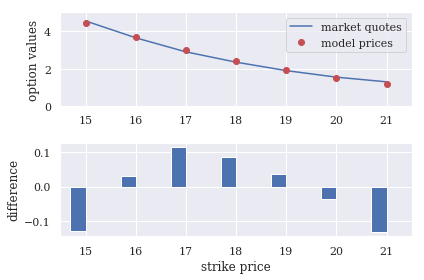

In [29]:
plot_calibration_results(opt)

In [30]:
%time opt = model_calibration(option_data, rel=True, mat='2014-07-18')

 kappa  theta  sigma         MSE
 5.000 10.000  1.000     1.00000
 6.000 12.500  9.000     0.12866
 7.000 16.250  9.000     0.01167
 8.000 20.000  9.000     0.18546
 9.000 23.750  9.000     1.20473
10.000 27.500  9.000     3.86826
12.000 10.000  9.000     0.73475
13.000 13.750  9.000     0.41208
14.000 17.500  9.000     0.05791
15.000 21.250  9.000     0.15684
16.000 25.000  9.000     1.57671
17.000 28.750  9.000     5.26237
19.000 11.250  9.000     0.81013
20.000 15.000  9.000     0.45062
 kappa  theta  sigma         MSE
 5.000 20.000  5.000     0.00051
 5.848 19.927  5.295     0.00050
11.500 19.608  7.260     0.00049
12.731 19.585  7.638     0.00049
12.732 19.585  7.638     0.00049
Optimization terminated successfully.
         Current function value: 0.000495
         Iterations: 252
         Function evaluations: 450
CPU times: user 3.91 s, sys: 144 ms, total: 4.06 s
Wall time: 4.03 s


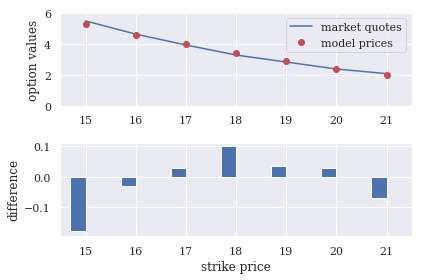

In [31]:
plot_calibration_results(opt)